In [ ]:
!pip install python-igraph

     |████████████████████████████████| 3.2MB 8.6MB/s 


In [ ]:
import igraph
import igraph as ig
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
plt.style.use('ggplot')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Let’s Help Santa!

##2. Build Your Graph

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:

#travel_time_path = "/content/drive/MyDrive/UCLA/large scale social and complex networks/project4/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"
#geo_path = "/content/drive/MyDrive/UCLA/large scale social and complex networks/project4/los_angeles_censustracts.json"

# i added a shortcut of shared project to my drive and uploaded the data into the shared drive lol. 
travel_time_path = "/content/drive/My Drive/ECE 232E Project/Project 4/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"
geo_path = "/content/drive/My Drive/ECE 232E Project/Project 4/los_angeles_censustracts.json"

# travel_time_path = "/content/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"
# geo_path = "/content/los_angeles_censustracts.json"


time_data = pd.read_csv(travel_time_path)
time_data = time_data[time_data['month']==12].reset_index(drop=True)
geo_data = pd.read_json(geo_path)
geo_data = pd.json_normalize(geo_data['features'])


FileNotFoundError: ignored

In [ ]:
print(time_data[time_data['sourceid']==665])
print(time_data[time_data['sourceid']==1522])

print(time_data[time_data['dstid']==665])
print(time_data[time_data['dstid']==1522])

         sourceid  ...  geometric_standard_deviation_travel_time
3759          665  ...                                      1.36
8286          665  ...                                      1.30
9322          665  ...                                      1.26
9900          665  ...                                      1.34
12961         665  ...                                      1.30
...           ...  ...                                       ...
1688313       665  ...                                      1.27
1690933       665  ...                                      1.32
1691977       665  ...                                      1.25
1692144       665  ...                                      1.29
1692315       665  ...                                      1.29

[869 rows x 7 columns]
         sourceid  ...  geometric_standard_deviation_travel_time
3642         1522  ...                                      1.33
7471         1522  ...                                      2.11
2

In [ ]:
# This code-block is just for debugging.

#with open(geo_path, "r") as geo_f:
#    geo_json = json.load(geo_f)
#    geo_data = pd.json_normalize(geo_json)
#print(geo_json['features'])
#for i, row in enumerate(geo_json['features']):
#    if i<1000:
#        print(row)

In [ ]:
print(time_data.columns)
print(geo_data.columns)
#print(geo_data.loc[:,'properties.DISPLAY_NAME'])
print(geo_data.loc[:,'geometry.coordinates'])


Index(['sourceid', 'dstid', 'month', 'mean_travel_time',
       'standard_deviation_travel_time', 'geometric_mean_travel_time',
       'geometric_standard_deviation_travel_time'],
      dtype='object')
Index(['type', 'properties.MOVEMENT_ID', 'properties.TRACT',
       'properties.DISPLAY_NAME', 'geometry.type', 'geometry.coordinates'],
      dtype='object')
0       [[[-118.11683, 34.107225], [-118.116311, 34.10...
1       [[[-118.134669, 34.098771], [-118.134644, 34.0...
2       [[[-118.134532, 34.091566], [-118.134623, 34.0...
3       [[[-118.12276, 34.10447], [-118.12386, 34.1039...
4       [[[-118.141784, 34.098765], [-118.141783, 34.0...
                              ...                        
2711    [[[-117.988457, 33.795667], [-117.988062, 33.7...
2712    [[[-118.072178, 33.795185], [-118.072182, 33.7...
2713    [[[-118.081682, 33.794065], [-118.08155, 33.79...
2714    [[[-118.07618, 33.785512], [-118.07618, 33.785...
2715    [[[-117.993727, 33.895404], [-117.992209, 33.8...
N

In [ ]:
from tqdm import tqdm
edge_dict = {}
edge_count = {}

for sourceid, dstid, time in tqdm(zip(time_data["sourceid"], time_data['dstid'], time_data['mean_travel_time'])):
    idx = (sourceid, dstid)
    if idx in edge_dict:
        edge_count[idx] += 1
        num = edge_count[idx]
        edge_dict[idx] = (num-1)/num * edge_dict[idx] + 1/num * time
        
    else:
        edge_count[idx] = 1
        edge_dict[idx] = time

edge_list = []
for key in tqdm(edge_dict):
    edge_list.append((key[0], key[1], edge_dict[key]))

1692450it [00:02, 608063.06it/s]
100%|██████████| 1692450/1692450 [00:01<00:00, 1294207.85it/s]


In [ ]:
# print(geo_data)
#print(dict((geo_data.head(2)['features'])))
def calculate_row_mean(geo_type, geo_coor):
    data = np.array(geo_coor)
    post_data = []
    #print(geo_type)
    #print(data.shape)
    if geo_type == "MultiPolygon":
        if data.shape[0]!=1 and len(data.shape)<=2: #handle Multipolygon case
            for i in data:
                for ii in i:
                    post_data.append(np.array(ii).mean(axis=0))
            post_data = np.array(post_data)
            cent_coor = post_data.mean(axis=0)
        elif data.shape[0]!=1 and len(data.shape)==4: #handle multippolygon but weird shape
            for i in data:
                post_data.append(i[0].mean(axis=0))
            post_data = np.array(post_data)
            cent_coor = post_data.mean(axis=0)
            #print(cent_coor)            
        else:
            print(data)
    else:
        if data.shape[0]!=1 and len(data.shape)!=2: # handle polygon case but weird shape
            for i in data:
                post_data.append(np.array(i).mean(axis=0))
            post_data = np.array(post_data)
            cent_coor = post_data.mean(axis=0)
            #print(cent_coor)
        elif data.shape[0]==1 and len(data.shape)==3:
            data = data.squeeze()
            cent_coor = data.mean(axis=0)
            #print(cent_coor)
            #for i in data[0][0]:
            #    print(len(i))
        else:
            print("hi")
    if cent_coor.shape[0]!=2:
        print(cent_coor.shape)
        print(geo_type)
        print(data.shape)
    return cent_coor
    '''
    if geo_type == "MultiPolygon":
        data = []
        for l in geo_coor:
            print(geo_type)
            print(np.array(l).shape)
    else:
        data = []
        print(geo_coor)
        print(np.array(geo_coor).shape)
        print(np.array(geo_coor))
    '''
    
geo_data_rename = geo_data.rename(columns={'type':'type', 'properties.MOVEMENT_ID': "movement_id", "properties.TRACT": 'tract', 
                                           "properties.DISPLAY_NAME":'display_name', "geometry.type": "geo_type", "geometry.coordinates":"geo_coor"})

geo_data_rename = geo_data_rename.drop(columns=['type', 'tract'])

#geo_data_rename['id'] = np.arange(len(geo_data_rename)) + 1
#for i, row in enumerate(geo_data_rename['geo_coor']):
node_list = []
for geo_type, geo_coor, id, display_name in zip(geo_data_rename['geo_type'], geo_data_rename['geo_coor'], geo_data_rename['movement_id'], geo_data_rename['display_name']):
    cent_coor = calculate_row_mean(geo_type, geo_coor)
    node_list.append((int(id), {"cent_coor":cent_coor, "display_name": display_name}))

#head_row = geo_data_rename.head(5)
#head_row.apply(calculate_row_mean)
#for row in head_row:
#    calculate_row_mean(row)
#a = geo_data_rename.head(1)['centroid'].to_numpy()

NameError: ignored

In [ ]:
# Create Graph with node list and edge list generated from above
G = nx.Graph()
G.add_nodes_from(node_list)
G.add_weighted_edges_from(edge_list)

# Only take the largest connected graph subgraph
largest_cc = max(nx.connected_components(G), key=len)
G0 = G.subgraph(largest_cc)

for n, i in G0.nodes(data=True):
    if i['display_name']=='Census Tract 265301':
        print(i['cent_coor'][::-1])

[  34.07228988 -118.44451639]


In [ ]:
# Question 6
print("number of edges: ", len(G0.edges()))
print("number of nodes: ", len(G0.nodes()))

number of edges:  1004955
number of nodes:  2649


In [ ]:
# find the minimum spanning tree
 
MST = nx.minimum_spanning_tree(G0)

In [ ]:
print("number of edges in MST: ", len(MST.edges()))
print("number of nodes in MST: ", len(MST.nodes()))

number of edges in MST:  2648
number of nodes in MST:  2649


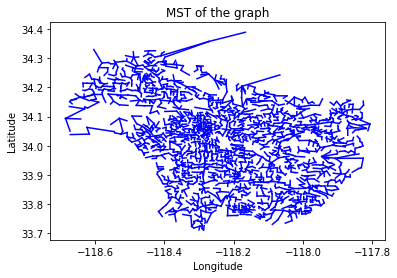

In [ ]:
for u, v, d in MST.edges(data=True):
    x = [MST.nodes[u]['cent_coor'][0], MST.nodes[v]['cent_coor'][0]]
    y = [MST.nodes[u]['cent_coor'][1], MST.nodes[v]['cent_coor'][1]]
    plt.plot(x, y, color = 'b')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MST of the graph')
plt.show()

In [ ]:
# display first 5 edges
for u, v, d in list(MST.edges(data=True))[:5]:
    print("Mean Traveling time: ", d['weight'])
    print(MST.nodes[u]['display_name'], "<------->", MST.nodes[v]['display_name'])
    print(MST.nodes[u]['cent_coor'][::-1], "<------->", MST.nodes[v]['cent_coor'][::-1])
    print(" ")

Mean Traveling time:  112.88
Census Tract 480302 <-------> Census Tract 481002
[  34.10309557 -118.12053321] <-------> [  34.09585388 -118.11656383]
 
Mean Traveling time:  128.71
Census Tract 480302 <-------> Census Tract 480400
[  34.10309557 -118.12053321] <-------> [  34.10349303 -118.13224544]
 
Mean Traveling time:  86.31
Census Tract 480303 <-------> Census Tract 480304
[  34.09645121 -118.13785063] <-------> [  34.09626386 -118.13138209]
 
Mean Traveling time:  118.03
Census Tract 480303 <-------> Census Tract 480400
[  34.09645121 -118.13785063] <-------> [  34.10349303 -118.13224544]
 
Mean Traveling time:  128.74
Census Tract 480303 <-------> Census Tract 480500
[  34.09645121 -118.13785063] <-------> [  34.0986815  -118.14492317]
 


In [ ]:
!pip install python-igraph
import json
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt 

     |████████████████████████████████| 3.2MB 23.2MB/s 


In [ ]:
# Question 8
df = pd.read_csv(travel_time_path)
df = df[df['month']==12][['sourceid','dstid','mean_travel_time']] #only december
new_df = pd.DataFrame(df.values,columns=['sourceid','dstid','mean_travel_time'])
new_df = new_df.groupby(['sourceid','dstid']).mean().reset_index()
new_df_vals = new_df.values


outfile = open("graph.txt", "w")
for i in range(len(new_df_vals)):
    line=str('%d'%int(new_df_vals[i][0]))+'\t'+str('%d'%int(new_df_vals[i][1]))+'\t'+str('%.3f'%new_df_vals[i][2]) + '\n'
    outfile.write(line)
outfile.close()


g = ig.Graph.Read(f = 'graph.txt', format = 'ncol', directed = False)
graph = g.components().giant()

# 8
triangles = []
while len(triangles)<1000:
    vertices = np.random.randint(1,high=len(graph.vs),size=3)
    try:
        e1 = graph.get_eid(vertices[0],vertices[1])
        e2 = graph.get_eid(vertices[1],vertices[2])
        e3 = graph.get_eid(vertices[2],vertices[0])
        weights = [graph.es['weight'][e1], graph.es['weight'][e2], graph.es['weight'][e3]]
        triangles.append(weights)
    except: continue

count = 0
for i in triangles:
    w1 = i[0]
    w2 = i[1]
    w3 = i[2]
    if w1+w2>w3 and w1+w3>w2 and w3+w2>w1:
        count+=1
print("The percentage of triangles in the graph is: ", count/len(triangles) * 100,"%")


NameError: ignored

In [ ]:
# Question 9

# The bound would be 2 since it is the 1-approximation algo



260551.60000000033
447269.3399999993
521103.20000000065
1.7166248067561234


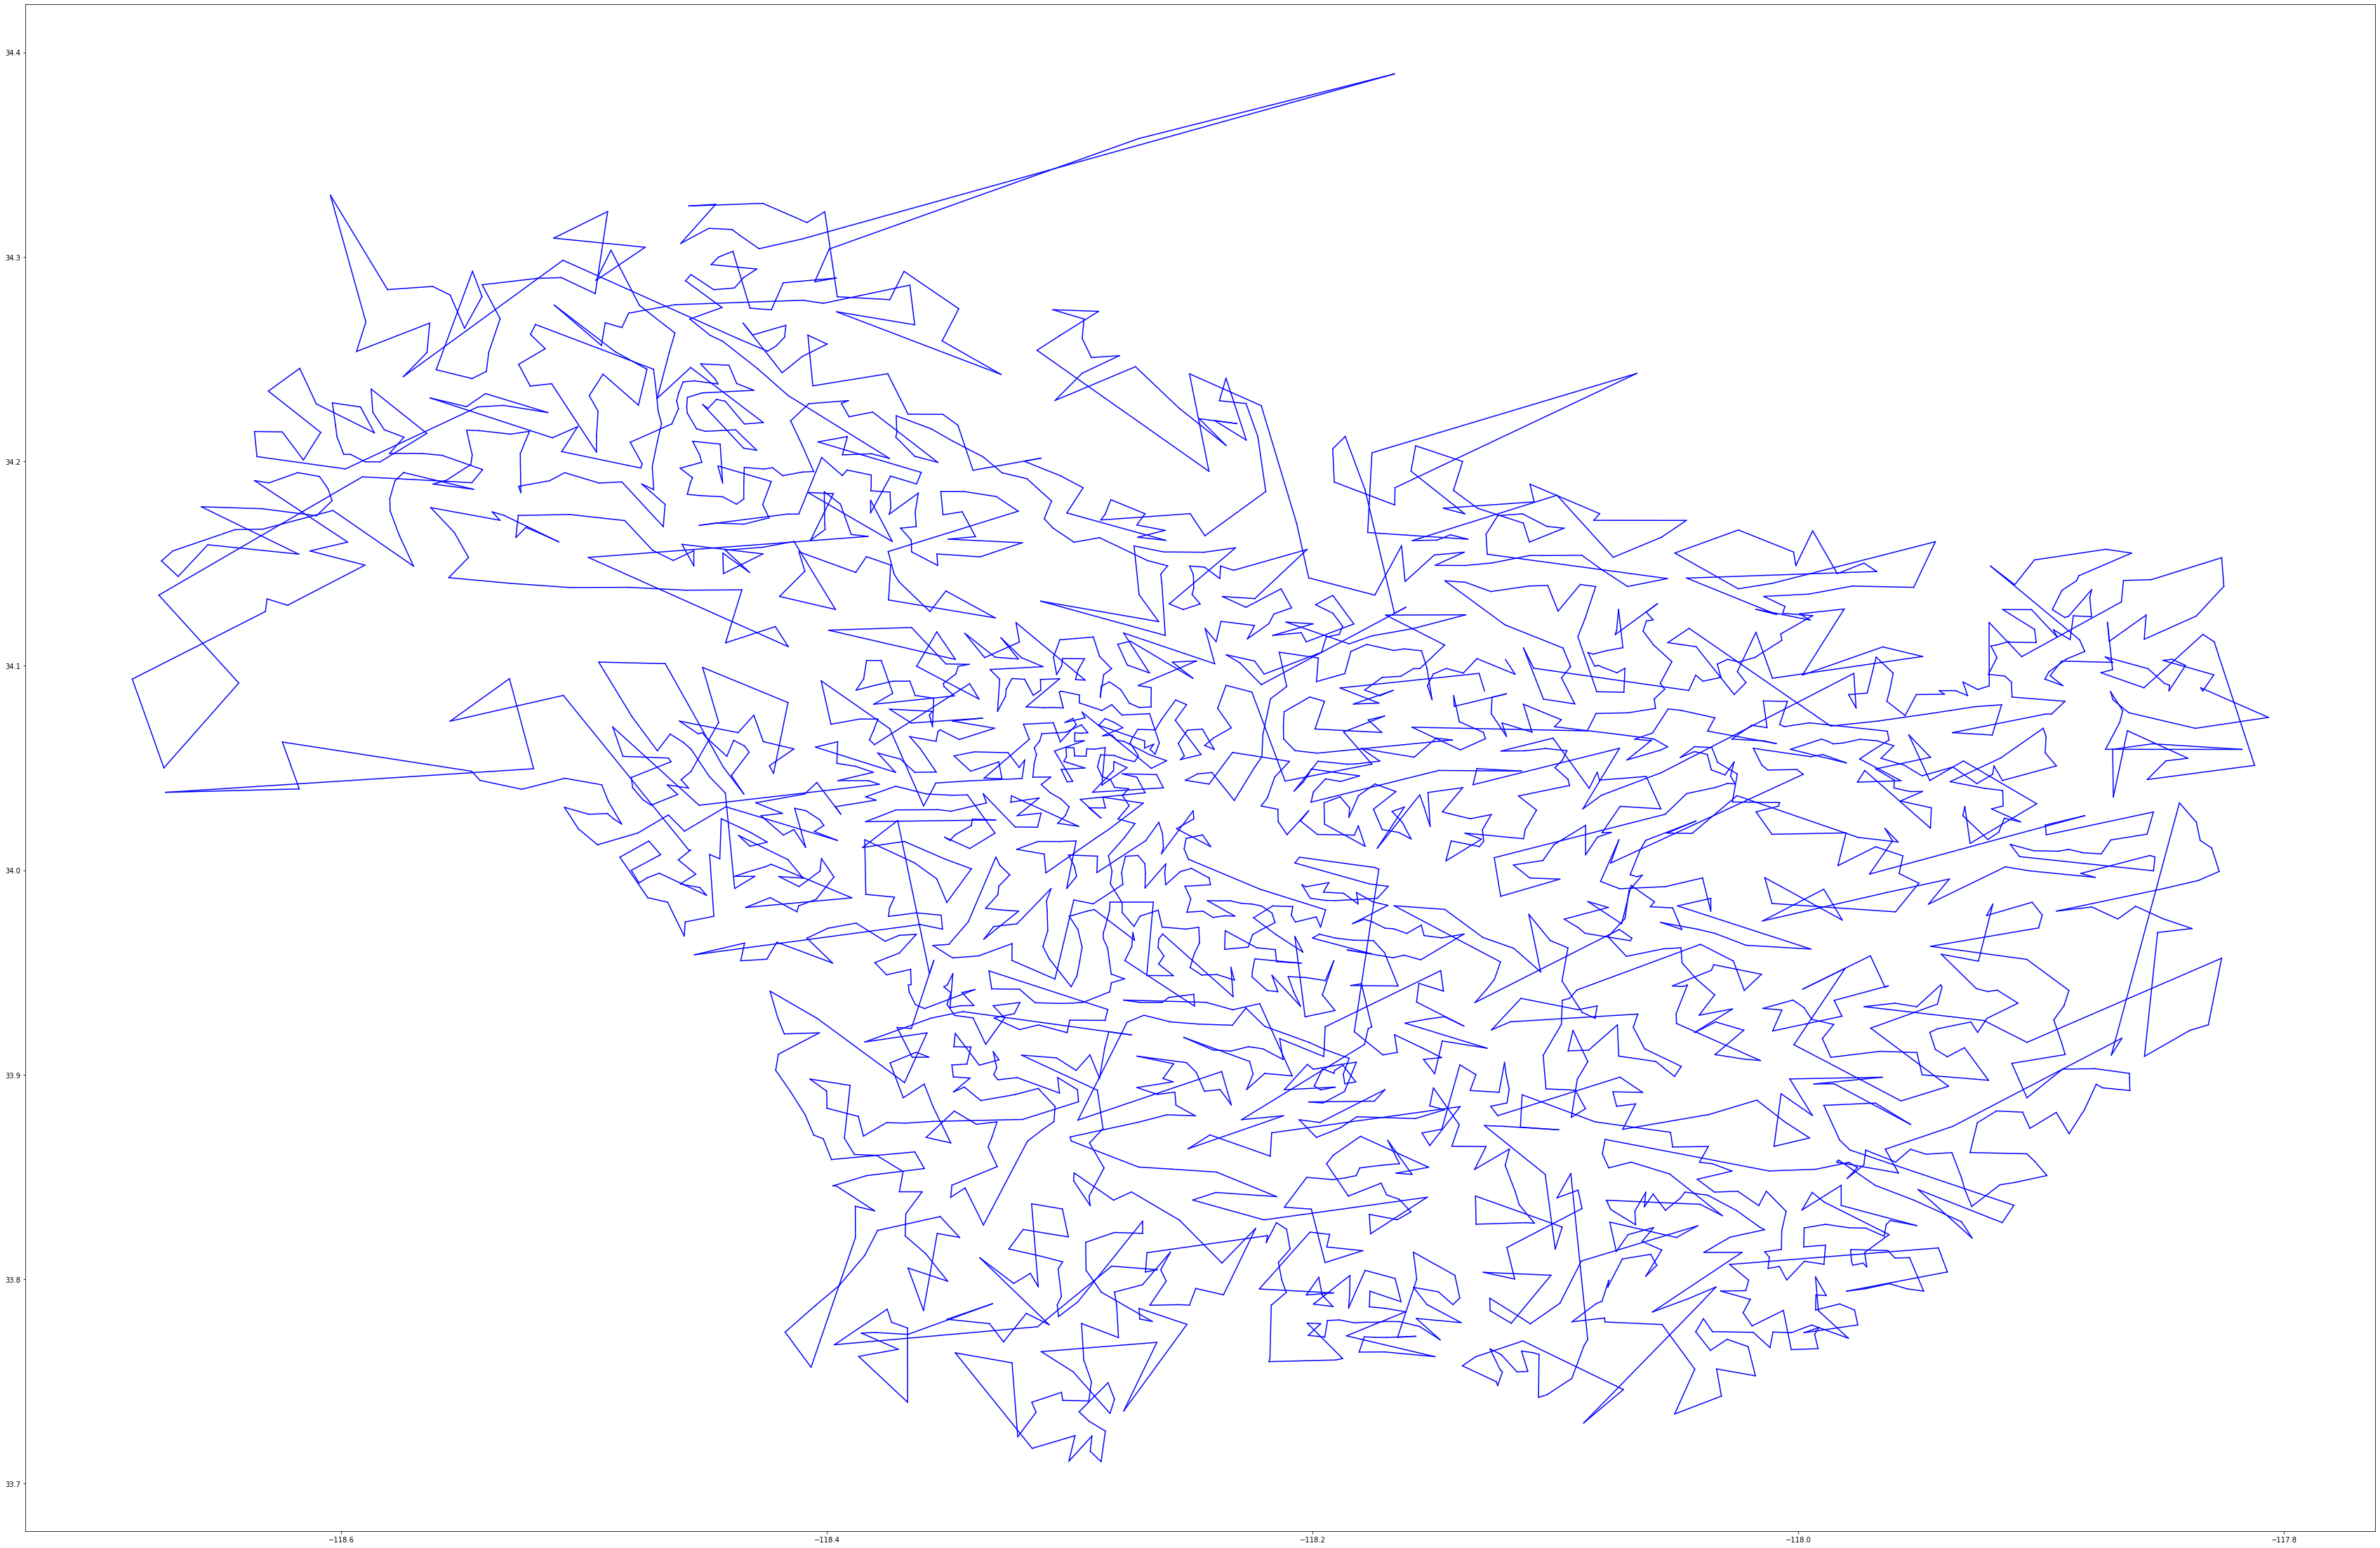

In [ ]:
# Question 10

bi_edge_list = []

MST_cost = 0
for u, v, d in MST.edges(data=True):
    bi_edge_list.append((u, v))
    bi_edge_list.append((v, u))
    MST_cost += d['weight']

H = nx.DiGraph()
H.add_nodes_from(MST)
H.add_edges_from(bi_edge_list)
edge_iter = nx.eulerian_path(H)

#print(len(H.edges))
#print(len([(u, v) for u, v in edge_iter]))
# if wanna print all the edges
plt.figure(figsize=(60,40))
traj = []
for u, v in edge_iter:
    traj.append(u)
    #x = [MST.nodes[u]['cent_coor'][0], MST.nodes[v]['cent_coor'][0]]
    #y = [MST.nodes[u]['cent_coor'][1], MST.nodes[v]['cent_coor'][1]]
    #plt.plot(x, y, color = 'b')
    #plt.arrow(x[0],y[0], x[1]-x[0], y[1]-y[0])
traj_once = []
for node in traj:
    if node not in traj_once:
        traj_once.append(node)
traj_len = 0
for i in range(len(traj_once)-1):
    try:
        traj_len += G0.edges[traj_once[i], traj_once[i+1]]['weight']
    except:
        traj_len += nx.shortest_path_length(G0, traj_once[i], traj_once[i+1])
    x = [MST.nodes[traj_once[i]]['cent_coor'][0], MST.nodes[traj_once[i+1]]['cent_coor'][0]]
    y = [MST.nodes[traj_once[i]]['cent_coor'][1], MST.nodes[traj_once[i+1]]['cent_coor'][1]]
    plt.plot(x, y, color = 'b')
    #plt.arrow(x[0],y[0], x[1]-x[0], y[1]-y[0])
print(MST_cost)
print(traj_len)
print(MST_cost*2)
print(traj_len/MST_cost)
plt.show()
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.title('MST of the graph')
#plt.show()

#travel_path = []
#for u, v in edge_iter:
#    travel_path.append((MST.nodes[u]['cent_coor'], MST.nodes[v]['cent_coor']))

In [ ]:
# This code-block requires google-map api.
import gmplot

apikey = '' # (your API key here)
gmap = gmplot.GoogleMapPlotter(travel_path[0][0][1], travel_path[0][0][0], 13, apikey=apikey)

for i, pair in enumerate(travel_path[:30]):
    gmap.marker(pair[0][1], pair[0][0], label=i)

gmap.draw('map.html')

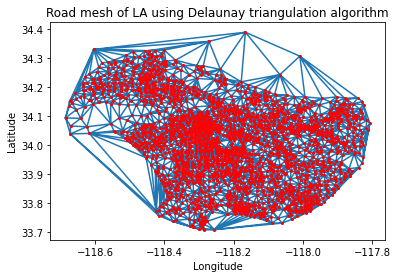

In [ ]:
#Question 11 
from scipy.spatial import Delaunay

lonlat_location = {}
with open(geo_path, 'r') as f:
    data = json.loads(f.readline())
    features = data['features']
    for feature in features:
        latitude = 0.0
        longitude = 0.0
        if feature['geometry']['type']=='Polygon':
            coordinates = np.array(feature['geometry']['coordinates'][0])

            for coordinate in coordinates:
                latitude += coordinate[1]
                longitude += coordinate[0]
        if feature['geometry']['type']=='MultiPolygon':
            coordinates = np.array(feature['geometry']['coordinates'][0][0])
            for coordinate in coordinates:
                latitude += coordinate[1]
                longitude += coordinate[0]
        latitude /= len(coordinates)
        longitude /= len(coordinates)
        
        lonlat_location[feature['properties']['MOVEMENT_ID']] = (feature['properties']['DISPLAY_NAME'], latitude, longitude)

lat=[]
lon=[]
for i in range(1,len(lonlat_location)+1):
    lat.append(lonlat_location[str(i)][1])
    lon.append(lonlat_location[str(i)][2])
lat_lon = tuple(zip(lat, lon)) 
tri = Delaunay(lat_lon)

g_delaunay=ig.Graph()
g_delaunay.add_vertices(len(tri.points))
vert=g_delaunay.vs()
i=0
for v in vert:
    v['lat']=lat[i]
    v['lon']=lon[i]
    i+=1

duplicates=set()
for i in range(len(tri.simplices)):
    a=((tri.simplices[i][0], tri.simplices[i][1]))
    b=((tri.simplices[i][0], tri.simplices[i][2]))
    c=((tri.simplices[i][1], tri.simplices[i][2]))
    list(a).sort()
    list(b).sort()
    list(c).sort()
    if not a in duplicates:
        duplicates.add(a)
        g_delaunay.add_edges([a])
    if not b in duplicates:
        duplicates.add(b)
        g_delaunay.add_edges([b])
    if not c in duplicates:
        duplicates.add(c)
        g_delaunay.add_edges([c])

plt.triplot(lon, lat, tri.simplices)
plt.plot(lon, lat,'r.',markersize=4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road mesh of LA using Delaunay triangulation algorithm')
plt.show()

In [ ]:
# Question 12 see report

In [ ]:
# Question 13
with open(geo_path) as json_data:
    geo_info = json.load(json_data)

geo_info = geo_info['features']
location_dict = {}
for features in geo_info:
    entry = {}
    coord = features['geometry']['coordinates'][0][0]
    if len(coord) > 2:
      mean_coord = np.mean(np.asarray(coord),axis=0)
    else:
      mean_coord = coord
    movement_id = features['properties']['MOVEMENT_ID']
    entry['coord'] = coord
    entry['mean_coord'] = mean_coord
    location_dict[movement_id] = entry

ig.Graph.write_ncol(graph,'data_q13.txt')
data_q13 = np.loadtxt('data_q13.txt')
data_q13_graph = {}
for row in data_q13:
    location_index = tuple(np.sort(row[0:2]).astype('int'))
    data_q13_graph[location_index] = row[2]
data_q13_ids = np.concatenate([data_q13[:,0],data_q13[:,1]])
data_q13_ids = np.unique(data_q13_ids).astype('int')

mean_coords = np.zeros((len(data_q13_ids),2))
for n,location_key in enumerate(data_q13_ids):
    mean_coords[n,:] = location_dict[str(location_key)]['mean_coord']
tri_q13 = Delaunay(mean_coords)

malibu= [34.04, -118.56]
long_beach =  [33.77, -118.18]

def get_flow(loc1, loc2, transit_time_graph):
    coord1 = location_dict[str(loc1)]['mean_coord']
    coord2 = location_dict[str(loc2)]['mean_coord']
    distance_miles = 69 * np.sqrt(np.sum(np.square(np.array(coord2)-np.array(coord1))))
    if (loc1,loc2) in transit_time_graph.keys():
        travel_time_hours = transit_time_graph[(loc1,loc2)] / 3600
        speed_mph = distance_miles / travel_time_hours
        flow = (2*speed_mph) / (0.003 + (speed_mph/1800))
        return flow
    else:
        return 0


def add_triangulated_edge(graph, triangle):
    edge12 = tuple(np.sort(triangle[:2]))
    edge13 = tuple(np.sort(triangle[0::2]))
    edge23 = tuple(np.sort(triangle[1:]))   

    flow12 = get_flow(edge12[0],edge12[1],data_q13_graph)
    flow13 = get_flow(edge13[0],edge13[1],data_q13_graph)
    flow23 = get_flow(edge23[0],edge23[1],data_q13_graph)
    if edge12 not in graph.keys() and flow12 > 0:
        graph[edge12] = flow12
    if edge13 not in graph.keys() and flow13 > 0:
        graph[edge13] = flow13
    if edge23 not in graph.keys() and flow23 > 0:
        graph[edge23] = flow23


triangulated_graph = {}
for triangle_idx in tri_q13.simplices:
    triangle = [data_q13_ids[triangle_idx[0]], data_q13_ids[triangle_idx[1]], data_q13_ids[triangle_idx[2]]]
    add_triangulated_edge(triangulated_graph,triangle)


with open('/triangulated_graph.txt','w') as f:
    for locations in triangulated_graph:
        string = '{} {} {:.2f}\n'.format(int(locations[0]),int(locations[1]),triangulated_graph[locations])
        f.write(string)

diff = np.ones(len(location_dict))
for i in location_dict.keys():
    diff[int(i)-1] = (np.stack(location_dict[i]['mean_coord'])[0]-(malibu[1]))**2+(np.stack(location_dict[i]['mean_coord'])[1]-(malibu[0]))**2
argmin_malibu = np.argmin(diff)
for i in location_dict.keys():
    diff[int(i)-1] = (np.stack(location_dict[i]['mean_coord'])[0]-(long_beach[1]))**2+(np.stack(location_dict[i]['mean_coord'])[1]-(long_beach[0]))**2
argmin_long_beach = np.argmin(diff)



In [ ]:
print("Degree of vertex for Malibu: ", g_delaunay.degree(argmin_malibu))
print("Degree of vertex for Long Beach: ", g_delaunay.degree(argmin_long_beach))
print("Number of edge disjoint paths:", g_delaunay.adhesion(argmin_malibu,argmin_long_beach))

Degree of vertex for Malibu:  6
Degree of vertex for Long Beach:  6
Number of edge disjoint paths: 6


Malibu Coordinates:  [-118.566222, 34.082256]


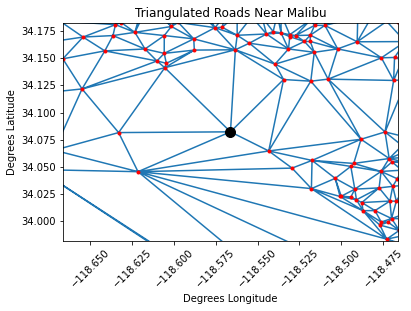

In [ ]:
Malibu_coords = location_dict[str(argmin_malibu)]['mean_coord']
print("Malibu Coordinates: ", Malibu_coords)
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri_q13.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.plot(Malibu_coords[0],Malibu_coords[1],'k.',ms=20)
plt.xlim((Malibu_coords[0]-0.1,Malibu_coords[0]+0.1))
plt.ylim((Malibu_coords[1]-0.1,Malibu_coords[1]+0.1))
plt.xticks(rotation = 45)
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads Near Malibu')
plt.show()

Long Beach Coordinates:  [-118.566222, 34.082256]


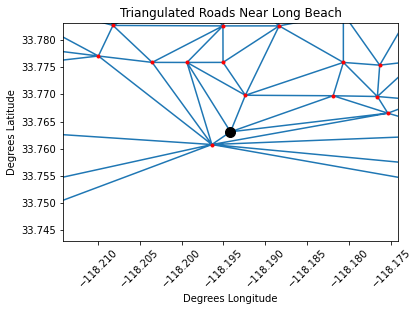

In [ ]:
LongBeach_coords = location_dict[str(argmin_long_beach)]['mean_coord']
print("Long Beach Coordinates: ", Malibu_coords)
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri_q13.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.plot(LongBeach_coords[0],LongBeach_coords[1],'k.',ms=20)
plt.xlim((LongBeach_coords[0]-0.02,LongBeach_coords[0]+0.02))
plt.ylim((LongBeach_coords[1]-0.02,LongBeach_coords[1]+0.02))
plt.xticks(rotation = 45)
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads Near Long Beach')
plt.show()

In [ ]:
def add_triangulated_edge(graph, triangle):
    edge12 = tuple(np.sort(triangle[:2]))
    edge13 = tuple(np.sort(triangle[0::2]))
    edge23 = tuple(np.sort(triangle[1:])) 

    flow12 = get_flow(edge12[0],edge12[1],data_q13_graph)
    flow13 = get_flow(edge13[0],edge13[1],data_q13_graph)
    flow23 = get_flow(edge23[0],edge23[1],data_q13_graph)
    if edge12 not in graph.keys() and flow12 > 0:
        graph[edge12] = flow12
    if edge13 not in graph.keys() and flow13 > 0:
        graph[edge13] = flow13
    if edge23 not in graph.keys() and flow23 > 0:
        graph[edge23] = flow23


triangulated_graph = {}
i=0
for triangle_idx in tri_q13.simplices:
    if(i == argmin_malibu):
        triangle = [data_q13_ids[triangle_idx[0]], data_q13_ids[triangle_idx[1]], data_q13_ids[triangle_idx[2]]]
        add_triangulated_edge(triangulated_graph,triangle)
    i+=1

# triangulated_graph = {}
# triangle = [data_q13_ids[tri_q13.simplices[argmin_malibu][0]], data_q13_ids[tri_q13.simplices[argmin_malibu][1]], data_q13_ids[tri_q13.simplices[argmin_malibu][2]]]
# add_triangulated_edge(triangulated_graph,triangle)

Text(0.5, 1.0, 'Road mesh using Delaunay triangulation with unreal roads removed')

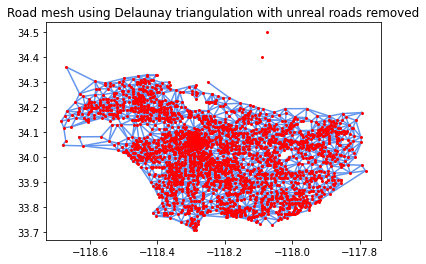

In [ ]:
# Question 14
triangulated_time_graph = {}
threshold = 60*12

def add_travel_time_edge(graph,triangle,thresh):
    edge12 = tuple(np.sort(triangle[:2]))
    edge13 = tuple(np.sort(triangle[0::2]))
    edge23 = tuple(np.sort(triangle[1:]))   
    
    time12, time13, time23 = 0,0,0
    if (edge12[0],edge12[1]) in data_q13_graph.keys():
        time12 = data_q13_graph[(edge12[0],edge12[1])]
    if (edge13[0],edge13[1]) in data_q13_graph.keys():
        time13 = data_q13_graph[(edge13[0],edge13[1])]
    if (edge23[0],edge23[1]) in data_q13_graph.keys():
        time23 = data_q13_graph[(edge23[0],edge23[1])]
    
    if edge12 not in graph.keys() and time12 < thresh and time12 > 0:
        graph[edge12] = time12
    if edge13 not in graph.keys() and time13 < thresh and time13 > 0:
        graph[edge13] = time13
    if edge23 not in graph.keys() and time23 < thresh and time23 > 0:
        graph[edge23] = time23

for triangle_idx in tri_q13.simplices:
    triangle = [data_q13_ids[triangle_idx[0]], data_q13_ids[triangle_idx[1]], data_q13_ids[triangle_idx[2]]]
    add_travel_time_edge(triangulated_time_graph, triangle, threshold)


plt.figure()
counter = 0
for edges in triangulated_time_graph.keys():
    coords1 = location_dict[str(edges[0])]['mean_coord']
    coords2 = location_dict[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='cornflowerblue')
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.', ms = 4)
plt.title('Road mesh using Delaunay triangulation with unreal roads removed')

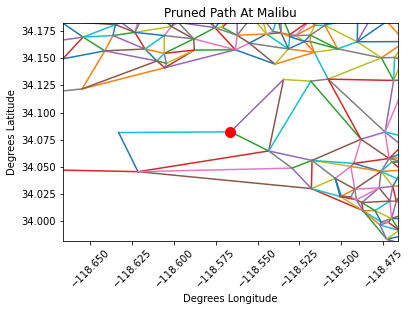

In [ ]:
# Question 15
Malibu_coords = location_dict[str(argmin_malibu)]['mean_coord']
for edges in triangulated_time_graph.keys():
    coords1 = location_dict[str(edges[0])]['mean_coord']
    coords2 = location_dict[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]])
plt.plot(Malibu_coords[0],Malibu_coords[1],'r.',ms=20)
plt.xlim((Malibu_coords[0]-0.1,Malibu_coords[0]+0.1))
plt.ylim((Malibu_coords[1]-0.1,Malibu_coords[1]+0.1))
plt.xlabel('Degrees Longitude')
plt.xticks(rotation = 45)
plt.ylabel('Degrees Latitude')
plt.title('Pruned Path At Malibu')
plt.show()

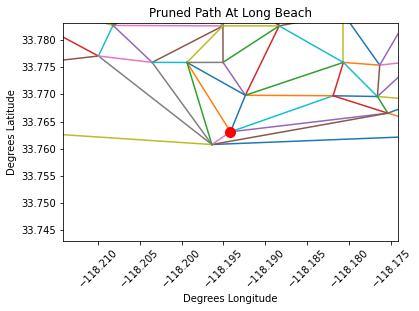

In [ ]:
LongBeach_coords = location_dict[str(argmin_long_beach)]['mean_coord']
for edges in triangulated_time_graph.keys():
    coords1 = location_dict[str(edges[0])]['mean_coord']
    coords2 = location_dict[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]])
plt.plot(LongBeach_coords[0],LongBeach_coords[1],'r.',ms=20)
plt.xlim((LongBeach_coords[0]-0.02,LongBeach_coords[0]+0.02))
plt.ylim((LongBeach_coords[1]-0.02,LongBeach_coords[1]+0.02))
plt.xticks(rotation = 45)
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Pruned Path At Long Beach')
plt.show()

# Define your own Task

## Day of week data

In [ ]:
travel_time_path = "/content/drive/MyDrive/UCLA/large scale social and complex networks/project4/los_angeles-taz-2019-3-WeeklyAggregate.csv"
geo_path = "/content/drive/MyDrive/UCLA/large scale social and complex networks/project4/los_angeles_censustracts.json"

# i added a shortcut of shared project to my drive and uploaded the data into the shared drive lol. 
#travel_time_path = "/content/drive/My Drive/ECE 232E Project/Project 4/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"
#geo_path = "/content/drive/My Drive/ECE 232E Project/Project 4/los_angeles_censustracts.json"

# travel_time_path = "/content/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"
# geo_path = "/content/los_angeles_censustracts.json"


time_data = pd.read_csv(travel_time_path)
#time_data = time_data[time_data['month']==12].reset_index(drop=True)
print(time_data)
geo_data = pd.read_json(geo_path)
geo_data = pd.json_normalize(geo_data['features'])


NameError: ignored

In [ ]:
time_data_weekday = time_data[(time_data['dow']>=1) & (time_data['dow']<=5)]
time_data_weekend = time_data[time_data['dow']>5]

In [ ]:
# print(geo_data)
#print(dict((geo_data.head(2)['features'])))
def calculate_row_mean(geo_type, geo_coor):
    data = np.array(geo_coor)
    post_data = []
    #print(geo_type)
    #print(data.shape)
    if geo_type == "MultiPolygon":
        if data.shape[0]!=1 and len(data.shape)<=2: #handle Multipolygon case
            for i in data:
                for ii in i:
                    post_data.append(np.array(ii).mean(axis=0))
            post_data = np.array(post_data)
            cent_coor = post_data.mean(axis=0)
        elif data.shape[0]!=1 and len(data.shape)==4: #handle multippolygon but weird shape
            for i in data:
                post_data.append(i[0].mean(axis=0))
            post_data = np.array(post_data)
            cent_coor = post_data.mean(axis=0)
            #print(cent_coor)            
        else:
            print(data)
    else:
        if data.shape[0]!=1 and len(data.shape)!=2: # handle polygon case but weird shape
            for i in data:
                post_data.append(np.array(i).mean(axis=0))
            post_data = np.array(post_data)
            cent_coor = post_data.mean(axis=0)
            #print(cent_coor)
        elif data.shape[0]==1 and len(data.shape)==3:
            data = data.squeeze()
            cent_coor = data.mean(axis=0)
            #print(cent_coor)
            #for i in data[0][0]:
            #    print(len(i))
        else:
            print("hi")
    if cent_coor.shape[0]!=2:
        print(cent_coor.shape)
        print(geo_type)
        print(data.shape)
    return cent_coor
    '''
    if geo_type == "MultiPolygon":
        data = []
        for l in geo_coor:
            print(geo_type)
            print(np.array(l).shape)
    else:
        data = []
        print(geo_coor)
        print(np.array(geo_coor).shape)
        print(np.array(geo_coor))
    '''
    
geo_data_rename = geo_data.rename(columns={'type':'type', 'properties.MOVEMENT_ID': "movement_id", "properties.TRACT": 'tract', 
                                           "properties.DISPLAY_NAME":'display_name', "geometry.type": "geo_type", "geometry.coordinates":"geo_coor"})

geo_data_rename = geo_data_rename.drop(columns=['type', 'tract'])

#geo_data_rename['id'] = np.arange(len(geo_data_rename)) + 1
#for i, row in enumerate(geo_data_rename['geo_coor']):
node_list = []
for geo_type, geo_coor, id, display_name in zip(geo_data_rename['geo_type'], geo_data_rename['geo_coor'], geo_data_rename['movement_id'], geo_data_rename['display_name']):
    cent_coor = calculate_row_mean(geo_type, geo_coor)
    node_list.append((int(id), {"cent_coor":cent_coor, "display_name": display_name}))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [ ]:
#UCLA: 265301: 1535
#senta monica: 701402, id: 1956
#Abbot Kinney Venice id: 1594
#Finantial dist id: 1254

for loc in node_list:
    if loc[1]['display_name']=='Census Tract 265301':
        print("UCLA id: ", loc[0])

    elif loc[1]['display_name']=='Census Tract 273300':
        print("Abbot Kinney Venice id: ", loc[0])

    elif loc[1]['display_name']=='Census Tract 207500':
        print("Finantial district id: ", loc[0])
        print(loc[1]['cent_coor'][::-1])

distant = []
target_coor = [34.05324612573105, -118.25152621317241]
for loc in node_list:
    #print(target_coor - loc[1]['cent_coor'][::-1])
    d = target_coor - loc[1]['cent_coor'][::-1]
    d = np.sum(d**2)
    distant.append(d)


distant = np.array(distant)
print(distant.shape)
idx = np.argsort(distant)[0]
print(np.sort(distant))
print(node_list[idx])
print(node_list[idx][1]['cent_coor'][::-1])

UCLA id:  1535
Abbot Kinney Venice id:  1594
(2716,)
[8.69811015e-06 9.03364919e-06 4.31867151e-05 ... 1.93386260e-01
 1.98694087e-01 2.01226212e-01]
(1232, {'cent_coor': array([-118.25434041,   34.05412841]), 'display_name': 'Census Tract 207502'})
[  34.05412841 -118.25434041]


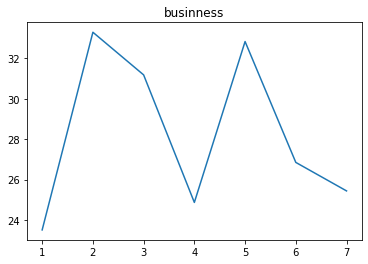

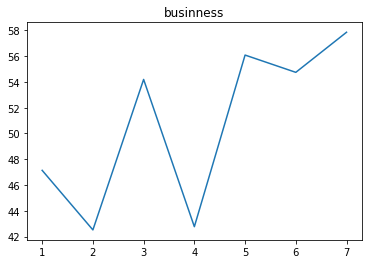

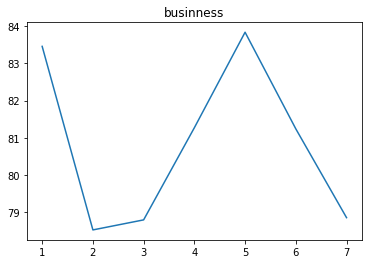

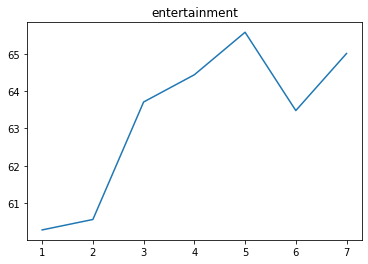

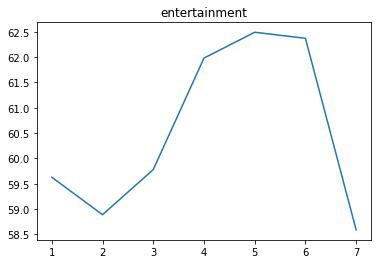

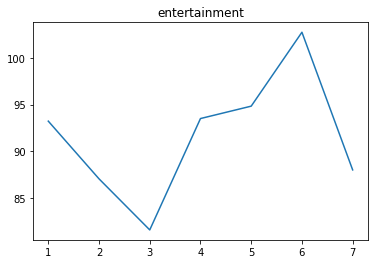

In [ ]:
#time_data[(time_data['dow']>=1) & (time_data['dow']<=5)]
def search_mean_travel_time(time_data, id, day):
    day_data = time_data[time_data['dow']==day]
    day_id_data = day_data[(day_data['sourceid']==id) | (day_data['dstid']==id)]
    if len(day_id_data)==0:
        return 0
    return np.min(day_id_data['geometric_mean_travel_time'])
    #return len(day_id_data)

time_bus_dist = []
for day in range(7):
    t = search_mean_travel_time(time_data, 1254, day+1)
    time_bus_dist.append(t)
plt.plot(np.arange(7)+1, time_bus_dist)
plt.title("businness")
plt.show()

time_bus_dist = []
for day in range(7):
    t = search_mean_travel_time(time_data, 1535, day+1)
    time_bus_dist.append(t)
plt.plot(np.arange(7)+1, time_bus_dist)
plt.title("businness")
plt.show()

time_bus_dist = []
for day in range(7):
    t = search_mean_travel_time(time_data, 1232, day+1)
    time_bus_dist.append(t)
plt.plot(np.arange(7)+1, time_bus_dist)
plt.title("businness")
plt.show()

time_ent_dist = []
for day in range(7):
    t = search_mean_travel_time(time_data, 1956, day+1)
    time_ent_dist.append(t)
plt.title("entertainment")
plt.plot(np.arange(7)+1, time_ent_dist)
plt.show()

time_ent_dist = []
for day in range(7):
    t = search_mean_travel_time(time_data, 1594, day+1)
    time_ent_dist.append(t)
plt.title("entertainment")
plt.plot(np.arange(7)+1, time_ent_dist)
plt.show()

time_ent_dist = []
for day in range(7):
    t = search_mean_travel_time(time_data, 2164, day+1)
    time_ent_dist.append(t)
plt.title("entertainment")
plt.plot(np.arange(7)+1, time_ent_dist)
plt.show()

In [ ]:
id = 2164
print(time_data[(time_data['sourceid']==id) | (time_data['dstid']==id)])

          sourceid  ...  geometric_standard_deviation_travel_time
3415          2129  ...                                      1.21
4434          1789  ...                                      1.21
9773          1484  ...                                      1.34
28640         2123  ...                                      1.17
32840          578  ...                                      1.33
...            ...  ...                                       ...
10430426      2015  ...                                      1.13
10434682       772  ...                                      1.27
10435587       814  ...                                      1.32
10438735       941  ...                                      1.31
10440023      1249  ...                                      1.15

[3391 rows x 7 columns]


In [ ]:
for idx in tqdm(np.random.randint(1, len(node_list), size=25)):
    id = node_list[idx][0]
    dist = []
    if_break = 0
    for day in range(7):
        t = search_mean_travel_time(time_data, id, day+1)
        if t==0:
            if_break = 1
            break
        dist.append(t)
    if if_break !=1:
        dist = np.array(dist)
        dist = dist - np.min(dist)
        dist = dist / np.max(dist)

        plt.plot(np.arange(7)+1, dist)
plt.show()

## This section based on hours of day in weekday and weekend data.
 

In [ ]:
travel_time_weekday_path = "/content/drive/MyDrive/UCLA/large scale social and complex networks/project4/los_angeles-censustracts-2019-3-OnlyWeekdays-HourlyAggregate.csv"
travel_time_weekend_path = "/content/drive/MyDrive/UCLA/large scale social and complex networks/project4/los_angeles-censustracts-2019-3-OnlyWeekends-HourlyAggregate.csv"
geo_path = "/content/drive/MyDrive/UCLA/large scale social and complex networks/project4/los_angeles_censustracts.json"


time_weekday_data = pd.read_csv(travel_time_weekday_path)
time_weekend_data = pd.read_csv(travel_time_weekend_path)
#time_data = time_data[time_data['month']==12].reset_index(drop=True)
print(time_weekend_data)
geo_data = pd.read_json(geo_path)
geo_data = pd.json_normalize(geo_data['features'])
print(time_weekend_data.columns)

          sourceid  ...  geometric_standard_deviation_travel_time
0              633  ...                                      1.30
1             1117  ...                                      1.39
2             1417  ...                                      1.53
3              606  ...                                      1.30
4             1963  ...                                      1.31
...            ...  ...                                       ...
20515922      1302  ...                                      1.19
20515923      1220  ...                                      1.41
20515924      1310  ...                                      1.22
20515925      1962  ...                                      1.22
20515926      1566  ...                                      1.31

[20515927 rows x 7 columns]
Index(['sourceid', 'dstid', 'hod', 'mean_travel_time',
       'standard_deviation_travel_time', 'geometric_mean_travel_time',
       'geometric_standard_deviation_travel_time'],
 

In [ ]:
id_set = set.intersection(set(time_weekday_data['sourceid']), set(time_weekday_data['dstid']), \
                                        set(time_weekend_data['sourceid']), set(time_weekend_data['dstid']))
                                                                          
print(len(id_set))

2637


In [ ]:
node_list_map = np.zeros((len(node_list), len(node_list)))

for i in range(len(node_list)):
    for j in range(i+1, len(node_list)):
        coor1 = node_list[i][1]['cent_coor']
        coor2 = node_list[j][1]['cent_coor']
        d = np.sum((coor1 - coor2)**2)
        node_list_map[i, j] = d
        node_list_map[j, i] = d

node_list_map = np.sqrt(node_list_map)

In [ ]:
def norm_func(row):
    i = int(row['sourceid'])
    j = int(row['dstid'])
    return node_list_map[i-1, j-1]

def search_mean_travel_time(time_data, id, hour):
    day_data = time_data[time_data['hod']==hour]
    day_id_data = day_data[(day_data['sourceid']==id) | (day_data['dstid']==id)]
    #dist = day_id_data.apply(lambda row: norm_func(row), axis=1)
    #idx = np.argmin(dist)
    #print(idx)
    if len(day_id_data)==0:
        return 0
    #ret = day_id_data['mean_travel_time'].iloc[idx]/dist.iloc[idx]
    #return ret
    return np.min(day_id_data['mean_travel_time'])
    #return len(day_id_data)

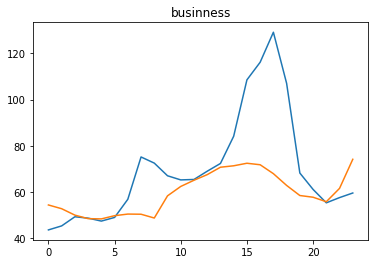

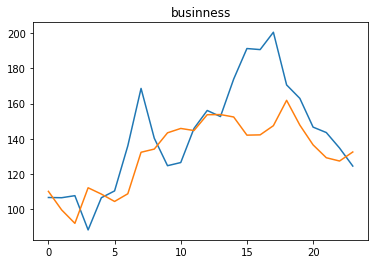

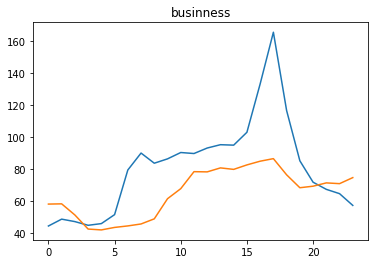

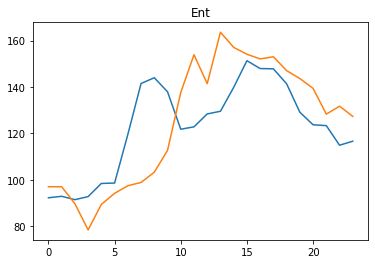

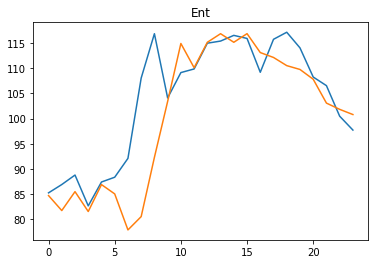

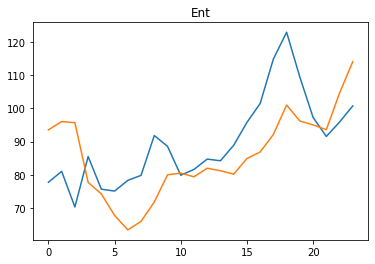

In [ ]:

time_bus_weekday_dist = []
for day in range(24):
    t = search_mean_travel_time(time_weekday_data, 1254, day)
    time_bus_weekday_dist.append(t)
time_bus_weekend_dist = []
for day in range(24):
    t = search_mean_travel_time(time_weekend_data, 1254, day)
    time_bus_weekend_dist.append(t)

plt.plot(np.arange(24), time_bus_weekday_dist)
plt.plot(np.arange(24), time_bus_weekend_dist)
plt.title("businness")
plt.show()


time_bus_weekday_dist = []
for day in range(24):
    t = search_mean_travel_time(time_weekday_data, 1535, day)
    time_bus_weekday_dist.append(t)
time_bus_weekend_dist = []
for day in range(24):
    t = search_mean_travel_time(time_weekend_data, 1535, day)
    time_bus_weekend_dist.append(t)

plt.plot(np.arange(24), time_bus_weekday_dist)
plt.plot(np.arange(24), time_bus_weekend_dist)
plt.title("businness")
plt.show()



time_bus_weekday_dist = []
for day in range(24):
    t = search_mean_travel_time(time_weekday_data, 1232, day)
    time_bus_weekday_dist.append(t)
time_bus_weekend_dist = []
for day in range(24):
    t = search_mean_travel_time(time_weekend_data, 1232, day)
    time_bus_weekend_dist.append(t)

plt.plot(np.arange(24), time_bus_weekday_dist)
plt.plot(np.arange(24), time_bus_weekend_dist)
plt.title("businness")
plt.show()

time_bus_weekday_dist = []
for day in range(24):
    t = search_mean_travel_time(time_weekday_data, 1956, day)
    time_bus_weekday_dist.append(t)
time_bus_weekend_dist = []
for day in range(24):
    t = search_mean_travel_time(time_weekend_data, 1956, day)
    time_bus_weekend_dist.append(t)

plt.plot(np.arange(24), time_bus_weekday_dist)
plt.plot(np.arange(24), time_bus_weekend_dist)
plt.title("Ent")
plt.show()

time_bus_weekday_dist = []
for day in range(24):
    t = search_mean_travel_time(time_weekday_data, 1594, day)
    time_bus_weekday_dist.append(t)
time_bus_weekend_dist = []
for day in range(24):
    t = search_mean_travel_time(time_weekend_data, 1594, day)
    time_bus_weekend_dist.append(t)

plt.plot(np.arange(24), time_bus_weekday_dist)
plt.plot(np.arange(24), time_bus_weekend_dist)
plt.title("Ent")
plt.show()

time_bus_weekday_dist = []
for day in range(24):
    t = search_mean_travel_time(time_weekday_data, 2164, day)
    time_bus_weekday_dist.append(t)
time_bus_weekend_dist = []
for day in range(24):
    t = search_mean_travel_time(time_weekend_data, 2164, day)
    time_bus_weekend_dist.append(t)

plt.plot(np.arange(24), time_bus_weekday_dist)
plt.plot(np.arange(24), time_bus_weekend_dist)
plt.title("Ent")
plt.show()

In [ ]:
import pickle
ftr = {}
from tqdm.notebook import tqdm
for idx, id in enumerate(tqdm(list(id_set)[2301:])):
    vec = []
    try:
        for hour in range(24): #handle weekday
            t = search_mean_travel_time(time_weekday_data, id, hour)
            vec.append(t)
        for hour in range(24): #handle weekend
            t = search_mean_travel_time(time_weekend_data, id, hour)
            vec.append(t)
    except:
        pass
    ftr[id] = np.array(vec)
    if idx%50 == 0:
        with open('/content/drive/MyDrive/UCLA/large scale social and complex networks/project4/ftr_1.pkl', 'wb') as f:
            pickle.dump(ftr, f)        

with open('/content/drive/MyDrive/UCLA/large scale social and complex networks/project4/ftr_1.pkl', 'wb') as f:
    pickle.dump(ftr, f)

In [ ]:
import pickle
with open('/content/drive/MyDrive/UCLA/large scale social and complex networks/project4/ftr.pkl', 'rb') as f:
    ftr = pickle.load(f)
print(len(ftr))

2301


In [ ]:
print(data.shape)

(2301, 48)


In [ ]:
data = []
ids = []
for key in ftr:
    ids.append(key)
    data.append(ftr[key])


In [ ]:
data = np.array(data)


In [ ]:
data_norm = []
for row in data:
    v = np.array(row[:24]) - np.array(row[24:])
    #v = v - np.min(v)
    #v = v/np.max(v)
    data_norm.append(v)
data_norm = np.array(data_norm)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(data_norm)
print(kmeans.labels_)



[1 1 1 ... 1 1 1]


In [ ]:
id_bus = [2108, 1697, 1535, 1232, 1197, 1615, 1572, 428, 142, 1320, 1841, 1234, 643]
id_ent = [1596, 433, 1089, 1095, 1687, 1916, 1720, 1965, 2164, 2403, 1228, 1229, 1888]

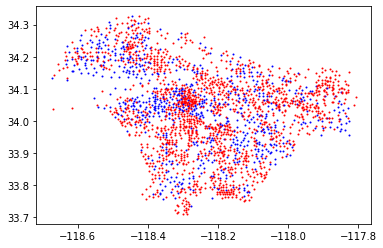

In [ ]:
bus_label = []
ent_label = []
colors=['b','r']
for i in range(len(ids)):
    id = ids[i]
    coor = node_list[id][1]['cent_coor']
    label = kmeans.labels_[i]
    if id in id_bus:
        bus_label.append(label)
    if id in id_ent:
        ent_label.append(label)
    plt.scatter(coor[0], coor[1], s=1, c=colors[label])
plt.show()

In [ ]:
print(bus_label)
print(ent_label)
print(np.sum(kmeans.labels_))
print(len(kmeans.labels_))
print("number of business label: ", np.sum(kmeans.labels_))
print("number of ent label:", len(kmeans.labels_)-np.sum(kmeans.labels_))

[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
1590
2301
number of business label:  1590
number of ent label: 711


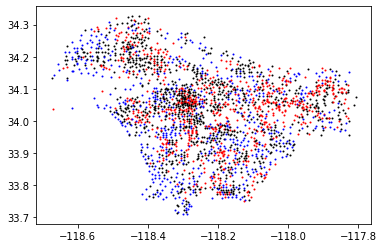

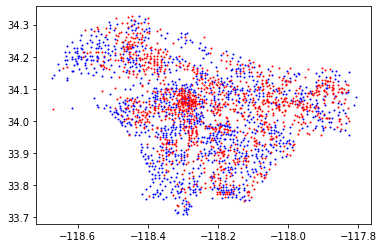

In [ ]:
data_norm = []
for row in data[:, :]:
    v = row
    #v = row - np.min(row)
    #v = v/np.max(v)
    data_norm.append(v)
data_norm = np.array(data_norm)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_norm)

colors=['b','r', 'k']
for i in range(len(ids)):
    id = ids[i]
    coor = node_list[id][1]['cent_coor']
    label = kmeans.labels_[i]

    plt.scatter(coor[0], coor[1], s=1, c=colors[label])
plt.show()

kmeans = KMeans(n_clusters=2, random_state=0).fit(data_norm)

colors=['b','r', 'k']
for i in range(len(ids)):
    id = ids[i]
    coor = node_list[id][1]['cent_coor']
    label = kmeans.labels_[i]

    plt.scatter(coor[0], coor[1], s=1, c=colors[label])
plt.show()